## Prepare Data

Prepare data for Train, Test, and Validation. Use them to try out different models.

In [2]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def get_rmse_score(model, X, y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
    rmse = np.sqrt(mse)
    return rmse

def get_train_rmse(model, X, y):
    model.fit(X, y)
    pred = model.predict(X)
    return mean_squared_error(y, pred)

import pandas as pd

seed = 42
df_train = pd.read_csv("data/train_clean.csv")

Y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)

print(f"Data Shapes:")
print(f"Train: {X_train.shape}")
print(f"Valid: {X_val.shape}")
print(f"Test:  {X_test.shape}")

Data Shapes:
Train: (1049, 280)
Valid: (117, 280)
Test:  (292, 280)


## Ridge and Lasso Linear Models

          RIDGE VS LASSO PERFORMANCE
----------------------------------------
Model  Train RMSE  Valid RMSE  Test RMSE
Ridge    0.089258    0.117072   0.122281
Lasso    0.092478    0.114743   0.120141


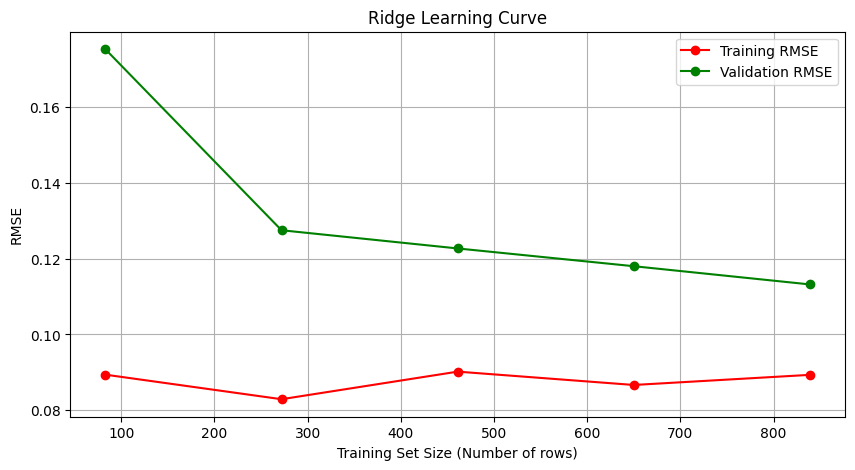

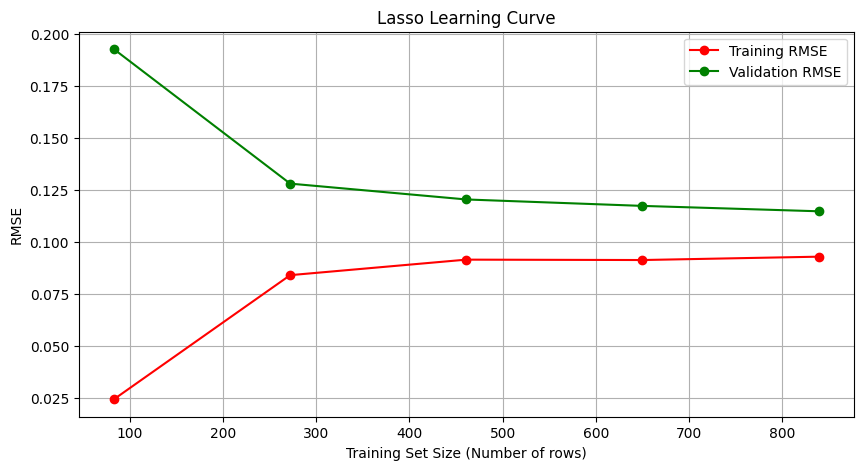

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

ridge_model = make_pipeline(
    RobustScaler(),
    RidgeCV(alphas=[0.1, 1, 5, 10, 20], cv=5)
)

lasso_model = make_pipeline(
    RobustScaler(),
    LassoCV(alphas=[0.0001, 0.0003, 0.0005, 0.001], cv=5, random_state=42)
)

ridge_model.fit(X_train, Y_train)
lasso_model.fit(X_train, Y_train)

def get_metrics(model, name):
    rmse_train = np.sqrt(mean_squared_error(Y_train, model.predict(X_train)))
    rmse_val   = np.sqrt(mean_squared_error(Y_val, model.predict(X_val)))
    rmse_test  = np.sqrt(mean_squared_error(Y_test, model.predict(X_test)))
    return [name, rmse_train, rmse_val, rmse_test]

results = []
results.append(get_metrics(ridge_model, "Ridge"))
results.append(get_metrics(lasso_model, "Lasso"))

df_results = pd.DataFrame(results, columns=["Model", "Train RMSE", "Valid RMSE", "Test RMSE"])
print("          RIDGE VS LASSO PERFORMANCE")
print("-"*40)
print(df_results.to_string(index=False))

def plot_sklearn_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, random_state=42
    )

    train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
    val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, val_rmse_mean, 'o-', color="g", label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training Set Size (Number of rows)")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Plot Curves
plot_sklearn_learning_curve(ridge_model, X_train, Y_train, "Ridge Learning Curve")
plot_sklearn_learning_curve(lasso_model, X_train, Y_train, "Lasso Learning Curve")

## XGBoost (Without and With Regularization)

XGBoost without any Regularization
 Dataset         RMSE
 Training    0.004651
Validation   0.146810
     Test    0.147750


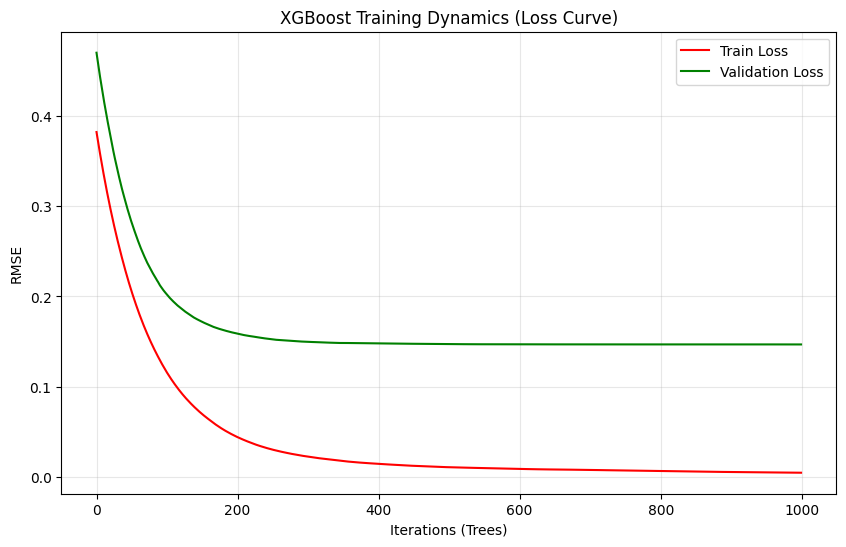

In [4]:
import matplotlib.pyplot as plt

xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.015, 
    max_depth=8, 
    n_jobs=-1,
    random_state=seed,
)

xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=False
)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

pred_train = xgb_model.predict(X_train)
pred_val   = xgb_model.predict(X_val)
pred_test  = xgb_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset    ': ['Training   ', 'Validation  ', 'Test   '],
    'RMSE': [rmse_train, rmse_val, rmse_test],
})

print("XGBoost without any Regularization")
print("="*40)
print(results_df.to_string(index=False))

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Loss', color='red')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation Loss', color='green')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations (Trees)')
plt.title('XGBoost Training Dynamics (Loss Curve)')
plt.grid(True, alpha=0.3)
plt.show()

XGBoost with Regularization
 Dataset         RMSE
 Training    0.039734
Validation   0.122399
     Test    0.121028


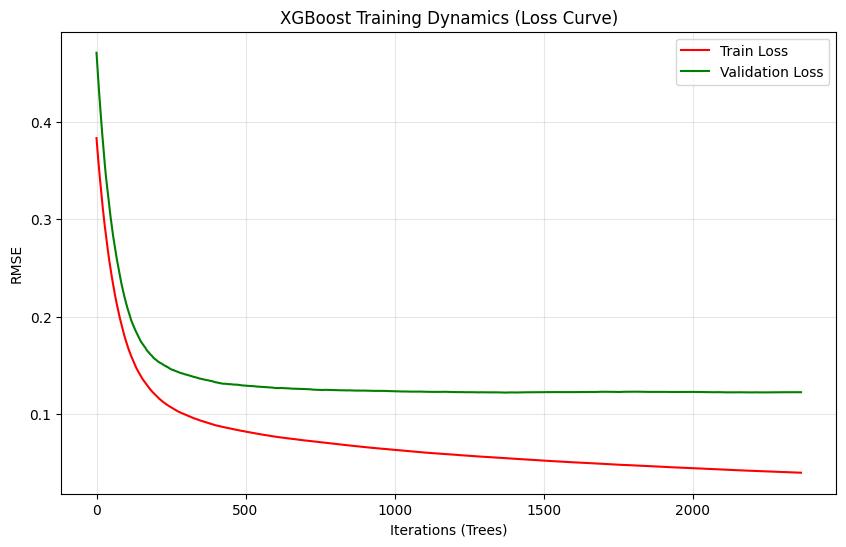

In [5]:
import matplotlib.pyplot as plt

xgb_model = XGBRegressor(
    n_estimators=2365, 
    learning_rate=0.015, 
    max_depth=3, 
    n_jobs=-1,
    random_state=seed,
    reg_alpha=0.02,         # L1 (Lasso): encourages sparsity (ignoring useless features)
    reg_lambda=3e-05,       # L2 (Ridge): discourages large weights (default is 1.0)
    subsample=0.6,          # Use only 80% of rows for each tree
    colsample_bytree=0.7,   # Use only 80% of features for each tree
)

xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=False
)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

pred_train = xgb_model.predict(X_train)
pred_val   = xgb_model.predict(X_val)
pred_test  = xgb_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset    ': ['Training   ', 'Validation  ', 'Test   '],
    'RMSE': [rmse_train, rmse_val, rmse_test],
})

print("XGBoost with Regularization")
print("="*30)
print(results_df.to_string(index=False))

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Loss', color='red')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation Loss', color='green')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations (Trees)')
plt.title('XGBoost Training Dynamics (Loss Curve)')
plt.grid(True, alpha=0.3)
plt.show()

## Support Vector Machine

SVR PERFORMANCE
------------------------------
      Dataset        RMSE
     Training    0.129720
   Validation    0.164946
Test (Unseen)    0.194326


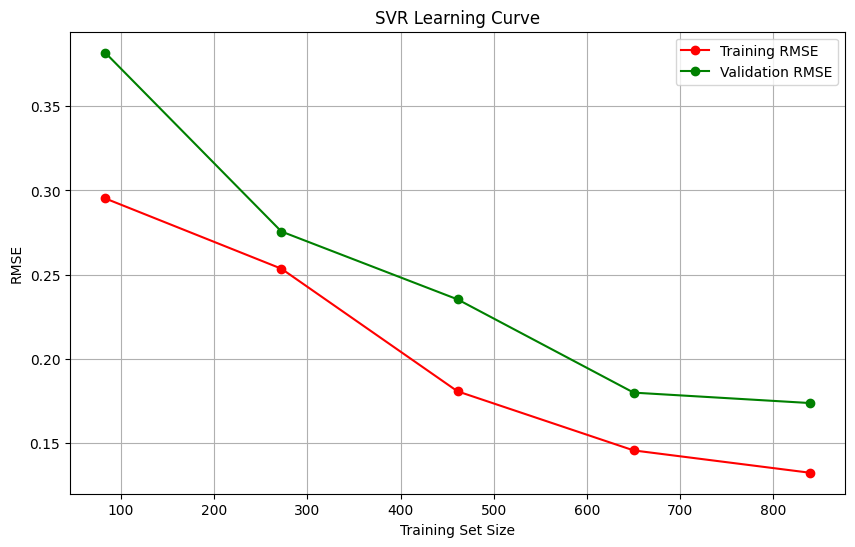

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

svr_model = make_pipeline(
    RobustScaler(),
    SVR(C=100, epsilon=0.01, gamma='scale', kernel='rbf')
)
svr_model.fit(X_train, Y_train)

pred_train = svr_model.predict(X_train)
pred_val   = svr_model.predict(X_val)
pred_test  = svr_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset   ': ['Training   ', 'Validation   ', 'Test (Unseen)   '],
    'RMSE': [rmse_train, rmse_val, rmse_test]
})

print("SVR PERFORMANCE")
print("-"*30)
print(results_df.to_string(index=False))

def plot_svr_learning_curve(estimator, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, 
        scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5), 
        n_jobs=-1, 
        random_state=42
    )

    train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
    val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, val_rmse_mean, 'o-', color="g", label="Validation RMSE")
    plt.title("SVR Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_svr_learning_curve(svr_model, X_train, Y_train)

## Neural Nets

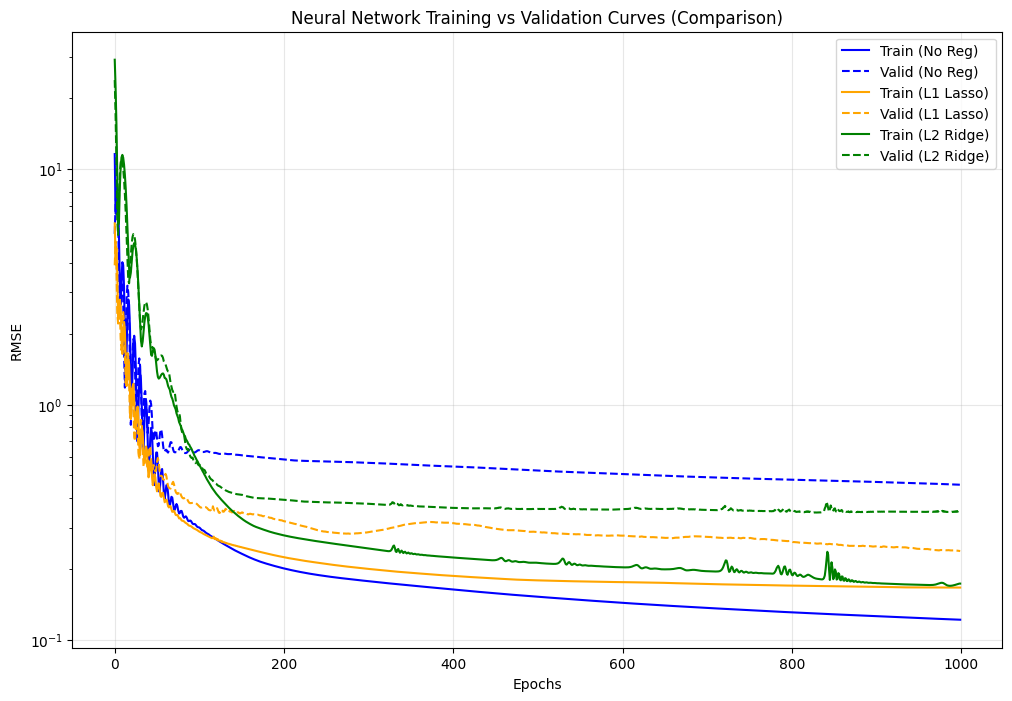


NEURAL NETWORK PERFORMANCE SUMMARY
--------------------------------------------------
           Method  Train RMSE  Valid RMSE  Test RMSE
No Regularization      0.1219      0.4565     0.2417
       L1 (Lasso)      0.1670      0.2387     0.2187
       L2 (Ridge)      0.1734      0.3530     0.2607
--------------------------------------------------


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')

X_train_t = torch.FloatTensor(X_train.values)
y_train_t = torch.FloatTensor(Y_train.values).view(-1, 1)

X_val_t   = torch.FloatTensor(X_val.values)
y_val_t   = torch.FloatTensor(Y_val.values).view(-1, 1)

X_test_t  = torch.FloatTensor(X_test.values)
y_test_t  = torch.FloatTensor(Y_test.values).view(-1, 1)

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32,32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

def train_model(reg_type='none', reg_strength=0.0, epochs=500, lr=0.01):
    model = Model(X_train_t.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        predictions = model(X_train_t)
        base_loss = criterion(predictions, y_train_t)

        reg_loss = 0
        if reg_type == 'l1':
            for param in model.parameters():
                reg_loss += torch.sum(torch.abs(param))
        elif reg_type == 'l2':
            for param in model.parameters():
                reg_loss += torch.sum(param ** 2)
        
        total_loss = base_loss + (reg_strength * reg_loss)
        total_loss.backward()
        optimizer.step()

        train_rmse = torch.sqrt(base_loss).item()
        train_loss_history.append(train_rmse)

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_rmse = torch.sqrt(criterion(val_pred, y_val_t)).item()
            val_loss_history.append(val_rmse)

    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_t)
        test_pred = model(X_test_t)
        
        final_train_rmse = np.sqrt(mean_squared_error(y_train_t, train_pred))
        final_val_rmse = val_loss_history[-1]
        final_test_rmse = np.sqrt(mean_squared_error(y_test_t, test_pred))
        
    return train_loss_history, val_loss_history, final_train_rmse, final_val_rmse, final_test_rmse

epochs = 1000
lr = 0.001
lambda_reg = 0.01

t_hist_none, v_hist_none, train_none, val_none, test_none = train_model(
    reg_type='none', reg_strength=lambda_reg, epochs=epochs, lr=lr
)
t_hist_l1, v_hist_l1, train_l1, val_l1, test_l1 = train_model(
    reg_type='l1', reg_strength=lambda_reg, epochs=epochs, lr=lr
)
t_hist_l2, v_hist_l2, train_l2, val_l2, test_l2 = train_model(
    reg_type='l2', reg_strength=lambda_reg, epochs=epochs, lr=lr
)

plt.figure(figsize=(12, 8))

plt.plot(t_hist_none, label='Train (No Reg)', color='blue')
plt.plot(v_hist_none, label='Valid (No Reg)', color='blue', linestyle='--')

plt.plot(t_hist_l1, label='Train (L1 Lasso)', color='orange')
plt.plot(v_hist_l1, label='Valid (L1 Lasso)', color='orange', linestyle='--')

plt.plot(t_hist_l2, label='Train (L2 Ridge)', color='green')
plt.plot(v_hist_l2, label='Valid (L2 Ridge)', color='green', linestyle='--')

plt.yscale('log')
plt.title('Neural Network Training vs Validation Curves (Comparison)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

results_df = pd.DataFrame({
    'Method': ['No Regularization', 'L1 (Lasso)', 'L2 (Ridge)'],
    'Train RMSE': [train_none, train_l1, train_l2],
    'Valid RMSE': [val_none, val_l1, val_l2],
    'Test RMSE':  [test_none, test_l1, test_l2]
})

print("\nNEURAL NETWORK PERFORMANCE SUMMARY")
print("-" * 50)
print(results_df.round(4).to_string(index=False))
print("-" * 50)

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_squared_error',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    # Convert negative MSE to RMSE
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Error")
    
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("RMSE (Log Scale)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

Score: 0.74
Mean Squared Error: 0.04
Index(['OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', 'KitchenAbvGr', 'GarageCars', 'Log_LotArea',
       'Log_GrLivArea', 'CentralAir_Y'],
      dtype='object')


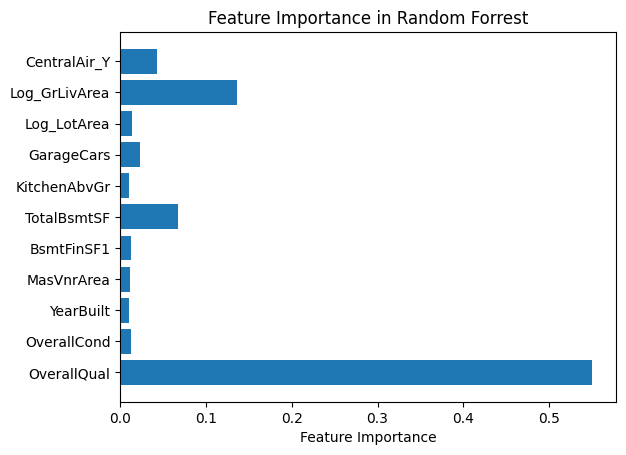

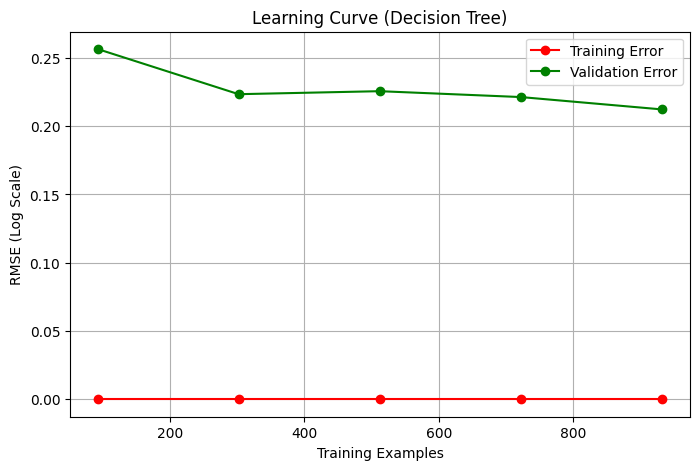

In [20]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split

seed = 42

# init decission tree classifier
clf = DecisionTreeRegressor(criterion="squared_error")

y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.2, random_state=seed)

clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

score = clf.score(X_test, Y_test)
print("Score: %.2f" % (score))

mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error: %.2f" % (mse))

feature_importances = clf.feature_importances_

threshold = .01
important_features = X_train.columns[feature_importances > threshold]
print(important_features)

# plt.barh(X_train.columns, feature_importances)
plt.barh(important_features, [x for x in feature_importances if x > threshold])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forrest")
plt.show()

plot_learning_curve(clf, "Learning Curve (Decision Tree)", X_train, Y_train)


Score: 0.88
Mean Squared Error: 0.02
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF',
       'GarageCars', 'Log_LotArea', 'Log_GrLivArea', 'CentralAir_Y'],
      dtype='object')


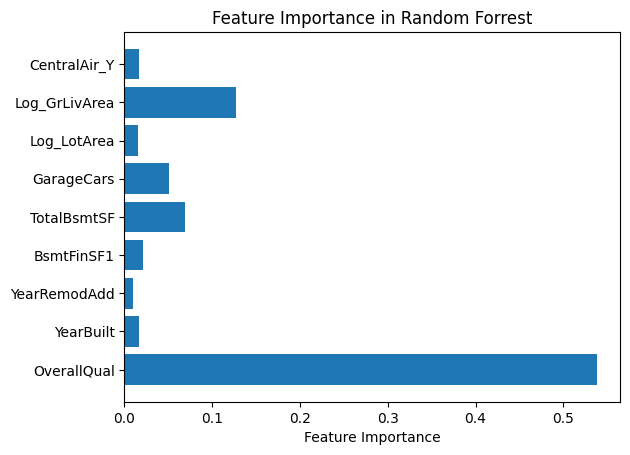

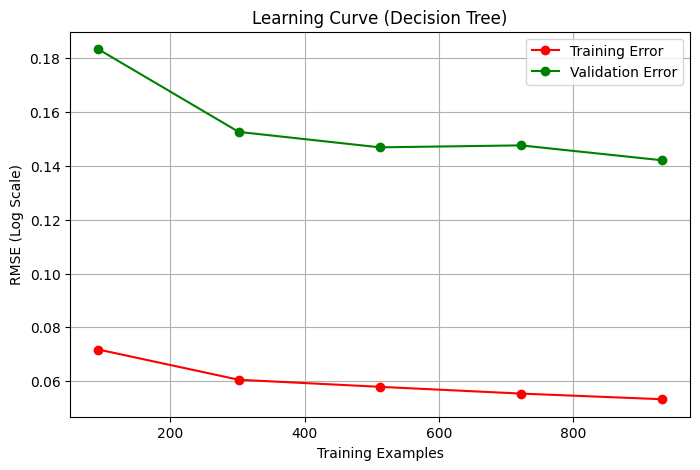

In [21]:
# Random Forest 
from sklearn.ensemble import RandomForestRegressor

rf_clf = RandomForestRegressor(n_estimators=100, random_state=seed)

y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.2, random_state=seed)

rf_clf.fit(X_train,Y_train)
Y_pred = rf_clf.predict(X_test)

score = rf_clf.score(X_test,Y_test)
print("Score: %.2f" % (score))

mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error: %.2f" % (mse))

feature_importances = rf_clf.feature_importances_

threshold = .01
important_features = X_train.columns[feature_importances > threshold]
print(important_features)

# plt.barh(X_train.columns, feature_importances)
plt.barh(important_features, [x for x in feature_importances if x > threshold])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forrest")
plt.show()

plot_learning_curve(rf_clf, "Learning Curve (Decision Tree)", X_train, Y_train)